Load the Dataset

In [1]:
import tensorflow as tf

# Define the directory of the training, validation, and test datasets
train_dir = 'C:/Users/Administrator/Desktop/Final Project   2025-1-1/Final Project/Stage_1_Dataset/train'
val_dir = 'C:/Users/Administrator/Desktop/Final Project   2025-1-1/Final Project/Stage_1_Dataset/validation'
test_dir = 'C:/Users/Administrator/Desktop/Final Project   2025-1-1/Final Project/Stage_1_Dataset/test'

# load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred', # automatically generate labels based on the folder names
    label_mode='binary', # binary classification
    image_size=(224, 224), # the size of the image
    batch_size=32, # the number of images in each batch
    shuffle=True # shuffle the data
)

# load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

# load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

# print the dataset information
class_names = train_ds.class_names
print("Class names:", class_names)

# view the first batch of the training dataset
for images, labels in train_ds.take(1):
    print("Train Image batch shape:", images.shape)
    print("Train Label batch shape:", labels.shape)

# view the first batch of the validation dataset
for images, labels in val_ds.take(1):
    print("Validation Image batch shape:", images.shape)
    print("Validation Label batch shape:", labels.shape)

# view the first batch of the test dataset
for images, labels in test_ds.take(1):
    print("Test Image batch shape:", images.shape)
    print("Test Label batch shape:", labels.shape)

Found 9998 files belonging to 2 classes.
Found 3332 files belonging to 2 classes.
Found 3336 files belonging to 2 classes.
Class names: ['False', 'True']
Train Image batch shape: (32, 224, 224, 3)
Train Label batch shape: (32, 1)
Validation Image batch shape: (32, 224, 224, 3)
Validation Label batch shape: (32, 1)
Test Image batch shape: (32, 224, 224, 3)
Test Label batch shape: (32, 1)


Visualizing Training Dataset


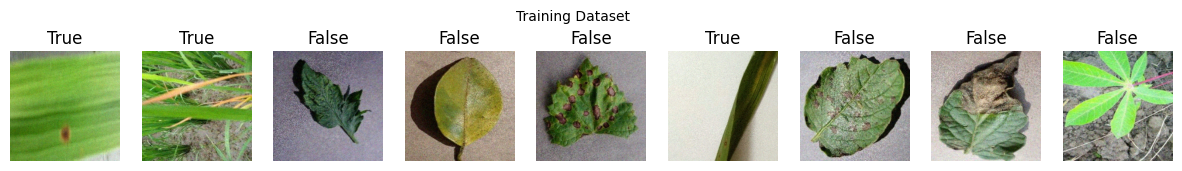

Visualizing Validation Dataset


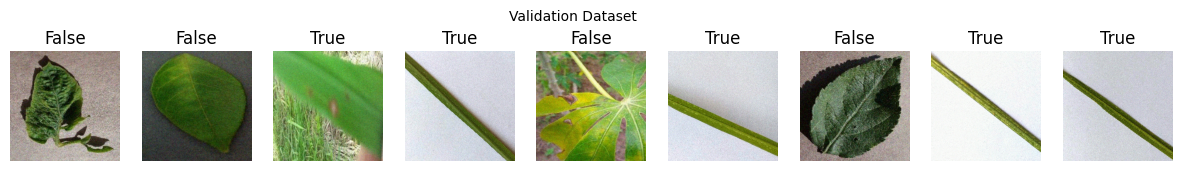

Visualizing Test Dataset


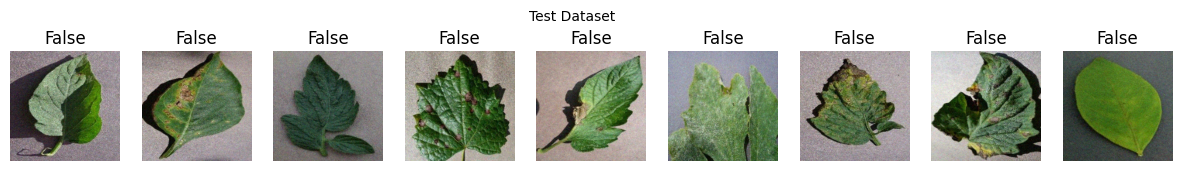

In [2]:
import matplotlib.pyplot as plt

# define a function to display images and labels
def visualize_dataset(dataset, class_names, num_images=9, title="Dataset Visualization"):
    plt.figure(figsize=(15, 2))  # adjust the image size to fit the horizontal display
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)  # display the images in one line
            plt.imshow(images[i].numpy().astype("uint8")) # display the image
            plt.title(class_names[int(labels[i])])
            plt.axis("off")
    plt.suptitle(title, fontsize=10)  # add the big title in the top of the figure
    plt.show()

# visualize the training dataset
print("Visualizing Training Dataset")
visualize_dataset(train_ds, class_names, title="Training Dataset")

# visualize the validation dataset
print("Visualizing Validation Dataset")
visualize_dataset(val_ds, class_names, title="Validation Dataset")

# visualize the test dataset
print("Visualizing Test Dataset")
visualize_dataset(test_ds, class_names, title="Test Dataset")

In [3]:
# To check the shape of the image and the label
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (32, 224, 224, 3)
Label:  [[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [4]:
from tensorflow.keras.layers import Rescaling

# define the normalization layer
normalization_layer = Rescaling(1./255)

# apply the normalization layer to the dataset
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [5]:
# Scramble images, set batch sizes, set repetitions, and set accelerated training before each iteration
def prepare_for_training(ds, cache=True):
    # If caching is enabled
    if cache:
        # If cache is a string, assume it's a file path and cache the data to a file
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            # Otherwise, keep the data in memory
            ds = ds.cache()
    # Shuffle the dataset using the provided buffer size
    ds = ds.shuffle(buffer_size=2000)

    return ds

In [6]:
# Recalculate the number of images in the training and validation datasets
TRAIN_IMG_COUNT = sum(1 for _ in train_ds.unbatch())
VAL_IMG_COUNT = sum(1 for _ in val_ds.unbatch())

print(f"Calculated number of training images: {TRAIN_IMG_COUNT}, Calculated number of validation images: {VAL_IMG_COUNT}")

Calculated number of training images: 9998, Calculated number of validation images: 3332


In [7]:
def change_batch_size(batch_size, ds):
    return ds.unbatch().repeat().batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [8]:
# Prepare the training and validation datasets
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Start the training process
### Define two callback strategies, one for hyperparameter tuning, and the other one for find the best performance

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

normal_callbacks = [
    EarlyStopping(patience=3, verbose=0, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-8, verbose=1, monitor='val_accuracy'),
]

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

VGG_callbacks = [
    EarlyStopping(patience=5, verbose=1, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-8, verbose=1, monitor='val_accuracy'),
    ModelCheckpoint('stage_1_model-VGGNet.weights.h5', verbose=1, save_best_only=True, monitor='val_accuracy'),
]

In [11]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.initializers import Constant
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l1_l2
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from tensorflow.keras import backend as K
import tensorflow_addons as tfa

def build_VGG16_model(dropout_rate, optimizer_choice, learning_rate, l1_reg, l2_reg, fc_units):
    # Create the base model which download in the Internet but it isn't freeze the weight of the layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # To freeze the layer
    for layer in base_model.layers:
        layer.trainable = False

    # Copare to the initial model, the Dense layer and the Dropout layer are changed
    x = Flatten()(base_model.output)
    x = Dense(fc_units, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(fc_units, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Choose the optimizer
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)    
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the model and set the loss function, optimizer and the evaluation metrics
    model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5)
              ])
    return model

e:\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
e:\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usi

In [12]:
# Will be used to find the best hyperparameters
def fit_VGG16(lr, batch_size_index, optimizer_index, dropout_rate, l1_reg, l2_reg, fc_units_index):
    K.clear_session()
    
    # List the hyperparameters to be selected as an array
    batch_sizes = [8, 16, 32]
    optimizer_choices = ['adam', 'sgd', 'rmsprop']
    fc_units_choices = [128, 256, 512]

    batch_size = batch_sizes[int(batch_size_index)]
    optimizer_choice = optimizer_choices[int(optimizer_index)]
    fc_units = fc_units_choices[int(fc_units_index)]
    print(f'Cerrent batch size is {batch_size} and fc_units is {fc_units}')

    # The hyperparameters of this iteration are trained
    VGG16_model = build_VGG16_model(dropout_rate=dropout_rate, optimizer_choice=optimizer_choice, learning_rate=lr, l1_reg=l1_reg, l2_reg=l2_reg, fc_units=fc_units)

    train_ds_local = change_batch_size(batch_size, train_ds)
    val_ds_local = change_batch_size(batch_size, val_ds)

    steps_per_epoch = max(1, TRAIN_IMG_COUNT // batch_size)
    validation_steps = max(1, VAL_IMG_COUNT // batch_size)

    # training the model and trying to find the best hyperparameter
    VGG_history = VGG16_model.fit(
        train_ds_local,
        steps_per_epoch=steps_per_epoch,
        epochs=15,
        verbose=1,
        validation_data=val_ds_local,
        validation_steps=validation_steps,
        callbacks=normal_callbacks
    )
    # get the best accuracy and validation accuracy will be the best hyperparameter evaluation index
    best_accuracy = max(VGG_history.history['val_accuracy'])
    return best_accuracy

In [13]:
# set the range of the hyperparameters which will be change in each iteration
HP_range = {
    'lr': (1e-4, 1e-3),
    'batch_size_index': (0, 3),
    'optimizer_index': (0, 3),
    'dropout_rate': (0.0, 0.5),
    'l1_reg': (1e-5, 1e-2),
    'l2_reg': (1e-5, 1e-2),
    'fc_units_index': (0, 3)
}

# set the Bayesian Optimization
VGG16_optimizer = BayesianOptimization(
    f=fit_VGG16, # function name, it will be called with different hyperparameters in each iteration
    pbounds=HP_range, # hyperparameters
    random_state=42, # random seed
    verbose= 2
)

# Record all iteration results in an external file for later presentation
logger = JSONLogger(path="./VGG_stage_1_logs.json")
VGG16_optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# Random search for two times, then 10 times Bayesian optimization to find the best hyperparameters
VGG16_optimizer.maximize(init_points=2, n_iter=10)

Cerrent batch size is 16 and fc_units is 512
Epoch 1/15
624/624 [==============================] - 52s 47ms/step - loss: 37.4654 - accuracy: 0.8738 - precision: 0.8485 - recall: 0.9101 - f1_score: 0.8782 - val_loss: 2.7263 - val_accuracy: 0.9303 - val_precision: 0.8938 - val_recall: 0.9765 - val_f1_score: 0.9333 - lr: 2.4040e-04
Epoch 2/15
624/624 [==============================] - 22s 35ms/step - loss: 2.6927 - accuracy: 0.8905 - precision: 0.8477 - recall: 0.9521 - f1_score: 0.8969 - val_loss: 2.6203 - val_accuracy: 0.9153 - val_precision: 0.8568 - val_recall: 0.9970 - val_f1_score: 0.9216 - lr: 2.4040e-04
Epoch 3/15
624/624 [==============================] - 22s 35ms/step - loss: 2.6436 - accuracy: 0.8988 - precision: 0.8563 - recall: 0.9583 - f1_score: 0.9045 - val_loss: 2.5631 - val_accuracy: 0.9333 - val_precision: 0.8902 - val_recall: 0.9886 - val_f1_score: 0.9368 - lr: 2.4040e-04
Epoch 4/15
624/624 [==============================] - 22s 35ms/step - loss: 2.6059 - accuracy: 0.90

In [14]:
# Define the mapping table manually
batch_sizes = [8, 16, 32]
optimizer_choices = ['adam', 'sgd', 'rmsprop']
fc_units_choices = [128, 256, 512]

# Initialize variables to store the best results
best_iteration = None
best_target = float('-inf')

# Print all the results of iterations each time
print("The result of all iteration of VGGNet:")
# Gets the hyperparameter of 12 iterations from the file
for i, res in enumerate(VGG16_optimizer.res):
    params = res['params']
    readable_params = {
        'batch_size': batch_sizes[int(params['batch_size_index'])],
        'optimizer': optimizer_choices[int(params['optimizer_index'])],
        'fc_units': fc_units_choices[int(params['fc_units_index'])],
        'dropout_rate': params['dropout_rate'],
        'l1_reg': params['l1_reg'],
        'l2_reg': params['l2_reg'],
        'lr': params['lr']
    }
    # Print the result of each iteration
    print(f"Iteration {i+1}:")
    print(f"Target: {res['target']:.4f}")
    print("Hyperparameters:")
    for key, value in readable_params.items(): 
        print(f"  {key}: {value}")
    print()

    # Update the best iteration result
    if res['target'] > best_target:
        best_target = res['target']
        best_iteration = (i+1, readable_params, best_target)

# Print the best result in 12 ineration
if best_iteration:
    iteration_number, params, target = best_iteration
    print("The best result of VGGNet is:")
    print(f"Iteration {iteration_number}:")
    print(f"Target: {target:.4f}")
    print("Parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")

The result of all iteration of VGGNet:
Iteration 1:
Target: 0.9471
Hyperparameters:
  batch_size: 16
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.4753571532049581
  l1_reg: 0.005990598257128396
  l2_reg: 0.001568626218019941
  lr: 0.00024039506830258236

Iteration 2:
Target: 0.9868
Hyperparameters:
  batch_size: 32
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.3005575058716044
  l1_reg: 0.00021563909801506647
  l2_reg: 0.009699399423098323
  lr: 0.0008491983767203796

Iteration 3:
Target: 0.9853
Hyperparameters:
  batch_size: 32
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.2575688367305503
  l1_reg: 0.0003667523807911495
  l2_reg: 0.003657981923223507
  lr: 0.0005312524126558976

Iteration 4:
Target: 0.9522
Hyperparameters:
  batch_size: 32
  optimizer: sgd
  fc_units: 256
  dropout_rate: 0.24583014029039424
  l1_reg: 0.0050146849548643
  l2_reg: 0.0018057819959022238
  lr: 0.000499875330866285

Iteration 5:
Target: 0.9688
Hyperparameters:
  batch_size: 32
  optimiz

In [15]:
VGG_best_params = VGG16_optimizer.max['params']

# Parse the best parameters
best_lr = VGG_best_params['lr']
best_batch_size_index = int(VGG_best_params['batch_size_index'])
best_optimizer_index = int(VGG_best_params['optimizer_index'])
best_dropout_rate = VGG_best_params['dropout_rate']
best_l1_reg = VGG_best_params['l1_reg']
best_l2_reg = VGG_best_params['l2_reg']
best_fc_units_index = int(VGG_best_params['fc_units_index'])

# Define the mapping table of batch_size and optimizer_choice
batch_sizes = [8, 16, 32]
optimizer_choices = ['adam', 'sgd', 'rmsprop']
fc_units_choices = [128, 256, 512]

# 获取实际的 batch_size, optimizer_choice 和 fc_units
best_batch_size = batch_sizes[best_batch_size_index]
best_optimizer_choice = optimizer_choices[best_optimizer_index]
best_fc_units = fc_units_choices[best_fc_units_index]

# Use the best parameters to build and train the model
K.clear_session()
VGG16_best_model = build_VGG16_model(dropout_rate=best_dropout_rate, optimizer_choice=best_optimizer_choice, learning_rate=best_lr, l1_reg=best_l1_reg, l2_reg=best_l2_reg, fc_units=best_fc_units)

train_ds_local = change_batch_size(best_batch_size, train_ds)
val_ds_local = change_batch_size(best_batch_size, val_ds)

steps_per_epoch = max(1, TRAIN_IMG_COUNT // best_batch_size)
validation_steps = max(1, VAL_IMG_COUNT // best_batch_size)

# Train the model again using a 
VGG16_best_history = VGG16_best_model.fit(
    train_ds_local,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_ds_local,
    validation_steps=validation_steps,
    callbacks=VGG_callbacks
)

# Print the new training result
new_best_accuacy = max(VGG16_best_history.history['val_accuracy'])
print("The new best accuracy in VGGNet is:", new_best_accuacy)

Epoch 1/20
312/312 [==============================] - ETA: 0s - loss: 1.7831 - accuracy: 0.9493 - precision: 0.9376 - recall: 0.9628 - f1_score: 0.9500
Epoch 1: val_accuracy improved from -inf to 0.94050, saving model to stage_1_model-VGGNet.weights.h5
312/312 [==============================] - 20s 61ms/step - loss: 1.7831 - accuracy: 0.9493 - precision: 0.9376 - recall: 0.9628 - f1_score: 0.9500 - val_loss: 0.7723 - val_accuracy: 0.9405 - val_precision: 0.8946 - val_recall: 0.9988 - val_f1_score: 0.9438 - lr: 4.0110e-04
Epoch 2/20
311/312 [============================>.] - ETA: 0s - loss: 0.5311 - accuracy: 0.9722 - precision: 0.9635 - recall: 0.9815 - f1_score: 0.9724
Epoch 2: val_accuracy improved from 0.94050 to 0.97206, saving model to stage_1_model-VGGNet.weights.h5
312/312 [==============================] - 19s 60ms/step - loss: 0.5305 - accuracy: 0.9723 - precision: 0.9636 - recall: 0.9816 - f1_score: 0.9725 - val_loss: 0.4142 - val_accuracy: 0.9721 - val_precision: 0.9496 - va

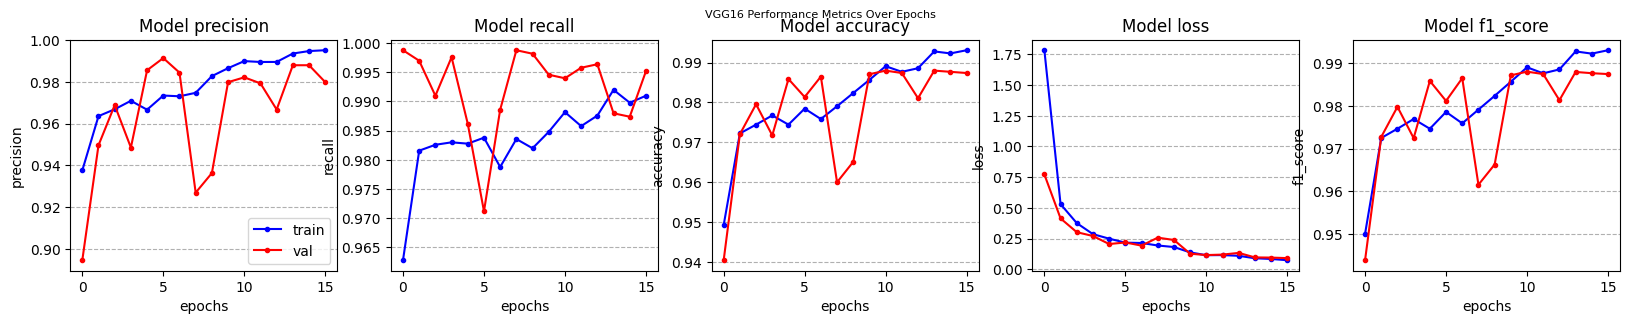

In [16]:
# Data visualization
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss', 'f1_score']):
    ax[i].plot(VGG16_best_history.history[met], color='blue', linestyle='-', marker='o', markersize=3)
    ax[i].plot(VGG16_best_history.history['val_' + met], color='red', linestyle='-', marker='o', markersize=3)
    if i == 0:
        ax[i].legend(['train', 'val'])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(axis='y', linestyle='--')

plt.suptitle('VGG16 Performance Metrics Over Epochs', fontsize=8)
plt.show()

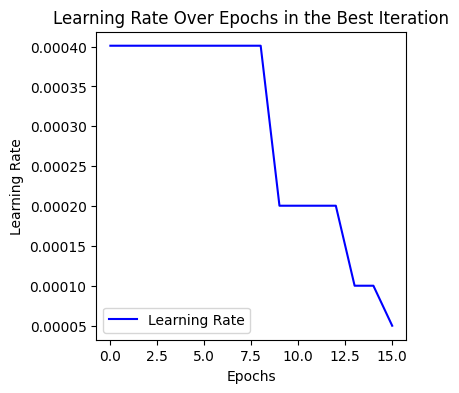

In [17]:
# print the learning rate
plt.figure(figsize=(4, 4))
plt.plot(VGG16_best_history.history['lr'], label='Learning Rate', color='b')
plt.title('Learning Rate Over Epochs in the Best Iteration')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

### DenseNet-121

In [18]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from tensorflow.keras import backend as K

def build_DenseNet121_model(dropout_rate, optimizer_choice, learning_rate, l1_reg, l2_reg, fc_units):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(fc_units, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(fc_units, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5)
                  ])
    return model

def fit_DenseNet121(lr, batch_size_index, optimizer_index, dropout_rate, l1_reg, l2_reg, fc_units_index):
    K.clear_session()
    
    batch_sizes = [8, 16, 32]
    optimizer_choices = ['adam', 'sgd', 'rmsprop']
    fc_units_choices = [128, 256, 512]

    batch_size = batch_sizes[int(batch_size_index)]
    optimizer_choice = optimizer_choices[int(optimizer_index)]
    fc_units = fc_units_choices[int(fc_units_index)]
    print(f'Current batch size is {batch_size} and fc_units is {fc_units}')

    DenseNet121_model = build_DenseNet121_model(dropout_rate=dropout_rate, optimizer_choice=optimizer_choice, learning_rate=lr, l1_reg=l1_reg, l2_reg=l2_reg, fc_units=fc_units)

    train_ds_local = change_batch_size(batch_size, train_ds)
    val_ds_local = change_batch_size(batch_size, val_ds)

    steps_per_epoch = max(1, TRAIN_IMG_COUNT // batch_size)
    validation_steps = max(1, VAL_IMG_COUNT // batch_size)

    DenseNet121_history = DenseNet121_model.fit(
        train_ds_local,
        steps_per_epoch=steps_per_epoch,
        epochs=15,
        verbose=1,
        validation_data=val_ds_local,
        validation_steps=validation_steps,
        callbacks=normal_callbacks
    )
    best_accuracy = max(DenseNet121_history.history['val_accuracy'])
    return best_accuracy

HP_range = {
    'lr': (1e-4, 1e-3),
    'batch_size_index': (0, 3),
    'optimizer_index': (0, 3),
    'dropout_rate': (0.0, 0.5),
    'l1_reg': (1e-5, 1e-2),
    'l2_reg': (1e-5, 1e-2),
    'fc_units_index': (0, 3)
}

DenseNet121_optimizer = BayesianOptimization(
    f=fit_DenseNet121,
    pbounds=HP_range,
    random_state=42,
    verbose=2
)

logger = JSONLogger(path="./DenseNet121_stage_1_logs.json")
DenseNet121_optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

DenseNet121_optimizer.maximize(init_points=2, n_iter=10)

Current batch size is 16 and fc_units is 512
Epoch 1/15
624/624 [==============================] - 33s 48ms/step - loss: 46.4003 - accuracy: 0.9499 - precision: 0.9375 - recall: 0.9641 - f1_score: 0.9506 - val_loss: 5.3569 - val_accuracy: 0.9678 - val_precision: 0.9555 - val_recall: 0.9814 - val_f1_score: 0.9683 - lr: 2.4040e-04
Epoch 2/15
624/624 [==============================] - 30s 48ms/step - loss: 4.8390 - accuracy: 0.9551 - precision: 0.9388 - recall: 0.9738 - f1_score: 0.9559 - val_loss: 4.6810 - val_accuracy: 0.9573 - val_precision: 0.9228 - val_recall: 0.9982 - val_f1_score: 0.9590 - lr: 2.4040e-04
Epoch 3/15
624/624 [==============================] - ETA: 0s - loss: 4.6627 - accuracy: 0.9538 - precision: 0.9345 - recall: 0.9762 - f1_score: 0.9549
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00012019753415129118.
624/624 [==============================] - 28s 46ms/step - loss: 4.6627 - accuracy: 0.9538 - precision: 0.9345 - recall: 0.9762 - f1_score: 0.9549 - val_lo

In [19]:
# Define the mapping table
batch_sizes = [8, 16, 32]
optimizer_choices = ['adam', 'sgd', 'rmsprop']
fc_units_choices = [128, 256, 512]

# Initialize variables to store the best results
best_iteration = None
best_target = float('-inf')

# Print the result of each iteration
print("The result of all iterations of DenseNet-121:")
for i, res in enumerate(DenseNet121_optimizer.res):
    params = res['params']
    readable_params = {
        'batch_size': batch_sizes[int(params['batch_size_index'])],
        'optimizer': optimizer_choices[int(params['optimizer_index'])],
        'fc_units': fc_units_choices[int(params['fc_units_index'])],
        'dropout_rate': params['dropout_rate'],
        'l1_reg': params['l1_reg'],
        'l2_reg': params['l2_reg'],
        'lr': params['lr']
    }
    # Print the result of each iteration
    print(f"Iteration {i+1}:")
    print(f"Target: {res['target']:.4f}")
    print("Hyperparameters:")
    for key, value in readable_params.items():
        print(f"  {key}: {value}")
    print()

    # Update the best iteration result
    if res['target'] > best_target:
        best_target = res['target']
        best_iteration = (i+1, readable_params, best_target)

# Print the best result
if best_iteration:
    iteration_number, params, target = best_iteration
    print("The best result of DenseNet-121 is:")
    print(f"Iteration {iteration_number}:")
    print(f"Target: {target:.4f}")
    print("Parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")

The result of all iterations of DenseNet-121:
Iteration 1:
Target: 0.9678
Hyperparameters:
  batch_size: 16
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.4753571532049581
  l1_reg: 0.005990598257128396
  l2_reg: 0.001568626218019941
  lr: 0.00024039506830258236

Iteration 2:
Target: 0.9907
Hyperparameters:
  batch_size: 32
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.3005575058716044
  l1_reg: 0.00021563909801506647
  l2_reg: 0.009699399423098323
  lr: 0.0008491983767203796

Iteration 3:
Target: 0.9955
Hyperparameters:
  batch_size: 32
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.2575688367305503
  l1_reg: 0.0003667523807911495
  l2_reg: 0.003657981923223507
  lr: 0.0005312524126558976

Iteration 4:
Target: 0.9754
Hyperparameters:
  batch_size: 32
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.13071523413241998
  l1_reg: 0.009087462467391285
  l2_reg: 0.007399790808650601
  lr: 0.0007118741470773452

Iteration 5:
Target: 0.9832
Hyperparameters:
  batch_size: 16

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

Dense_callbacks = [
    EarlyStopping(patience=5, verbose=1, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-8, verbose=1, monitor='val_accuracy'),
    ModelCheckpoint('stage_1_model-DenseNet.weights.h5', verbose=1, save_best_only=True, monitor='val_accuracy'),
]

In [21]:
DenseNet121_best_params = DenseNet121_optimizer.max['params']

best_lr = DenseNet121_best_params['lr']
best_batch_size_index = int(DenseNet121_best_params['batch_size_index'])
best_optimizer_index = int(DenseNet121_best_params['optimizer_index'])
best_dropout_rate = DenseNet121_best_params['dropout_rate']
best_l1_reg = DenseNet121_best_params['l1_reg']
best_l2_reg = DenseNet121_best_params['l2_reg']
best_fc_units_index = int(DenseNet121_best_params['fc_units_index'])

best_batch_size = batch_sizes[best_batch_size_index]
best_optimizer_choice = optimizer_choices[best_optimizer_index]
best_fc_units = fc_units_choices[best_fc_units_index]

K.clear_session()
DenseNet121_best_model = build_DenseNet121_model(dropout_rate=best_dropout_rate, optimizer_choice=best_optimizer_choice, learning_rate=best_lr, l1_reg=best_l1_reg, l2_reg=best_l2_reg, fc_units=best_fc_units)

train_ds_local = change_batch_size(best_batch_size, train_ds)
val_ds_local = change_batch_size(best_batch_size, val_ds)

steps_per_epoch = max(1, TRAIN_IMG_COUNT // best_batch_size)
validation_steps = max(1, VAL_IMG_COUNT // best_batch_size)

DenseNet121_best_history = DenseNet121_best_model.fit(
    train_ds_local,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_ds_local,
    validation_steps=validation_steps,
    callbacks=Dense_callbacks
)

new_best_accuracy = max(DenseNet121_best_history.history['val_accuracy'])
print("The new best accuracy in DenseNet-121 is:", new_best_accuracy)

Epoch 1/20
312/312 [==============================] - ETA: 0s - loss: 8.4954 - accuracy: 0.9744 - precision: 0.9712 - recall: 0.9778 - f1_score: 0.9745
Epoch 1: val_accuracy improved from -inf to 0.99339, saving model to stage_1_model-DenseNet.weights.h5
312/312 [==============================] - 24s 69ms/step - loss: 8.4954 - accuracy: 0.9744 - precision: 0.9712 - recall: 0.9778 - f1_score: 0.9745 - val_loss: 2.7231 - val_accuracy: 0.9934 - val_precision: 0.9958 - val_recall: 0.9910 - val_f1_score: 0.9934 - lr: 5.3125e-04
Epoch 2/20
311/312 [============================>.] - ETA: 0s - loss: 2.2965 - accuracy: 0.9823 - precision: 0.9788 - recall: 0.9859 - f1_score: 0.9824
Epoch 2: val_accuracy improved from 0.99339 to 0.99459, saving model to stage_1_model-DenseNet.weights.h5
312/312 [==============================] - 20s 65ms/step - loss: 2.2950 - accuracy: 0.9823 - precision: 0.9789 - recall: 0.9858 - f1_score: 0.9823 - val_loss: 1.7783 - val_accuracy: 0.9946 - val_precision: 0.9952 

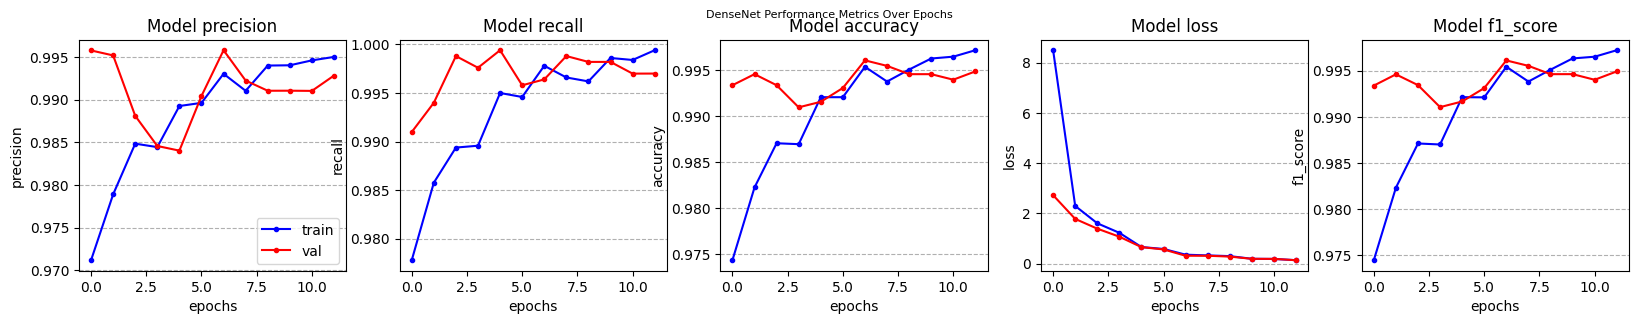

In [22]:
# Data visualization
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss', 'f1_score']):
    ax[i].plot(DenseNet121_best_history.history[met], color='blue', linestyle='-', marker='o', markersize=3)
    ax[i].plot(DenseNet121_best_history.history['val_' + met], color='red', linestyle='-', marker='o', markersize=3)
    
    if i == 0:
        ax[i].legend(['train', 'val'])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(axis='y', linestyle='--')

plt.suptitle('DenseNet Performance Metrics Over Epochs', fontsize=8)
plt.show()

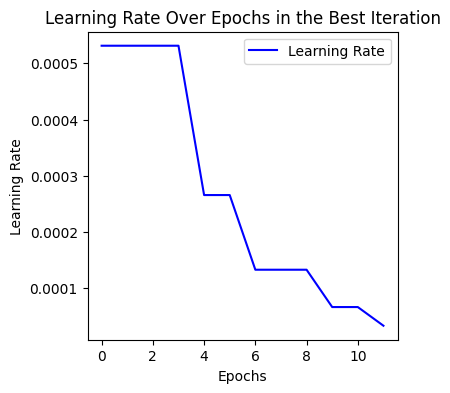

In [23]:
# print the learning rate
plt.figure(figsize=(4, 4))
plt.plot(DenseNet121_best_history.history['lr'], label='Learning Rate', color='b')
plt.title('Learning Rate Over Epochs in the Best Iteration')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

### MobileNet

In [24]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from tensorflow.keras import backend as K

def build_MobileNet_model(dropout_rate, optimizer_choice, learning_rate, l1_reg, l2_reg, fc_units):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(fc_units, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5)
                  ])
    return model

def fit_MobileNet(lr, batch_size_index, optimizer_index, dropout_rate, l1_reg, l2_reg, fc_units_index):
    K.clear_session()
    
    batch_sizes = [8, 16, 32]
    optimizer_choices = ['adam', 'sgd', 'rmsprop']
    fc_units_choices = [128, 256, 512]

    batch_size = batch_sizes[int(batch_size_index)]
    optimizer_choice = optimizer_choices[int(optimizer_index)]
    fc_units = fc_units_choices[int(fc_units_index)]
    print(f'Current batch size is {batch_size} and fc_units is {fc_units}')

    MobileNet_model = build_MobileNet_model(dropout_rate=dropout_rate, optimizer_choice=optimizer_choice, learning_rate=lr, l1_reg=l1_reg, l2_reg=l2_reg, fc_units=fc_units)

    train_ds_local = change_batch_size(batch_size, train_ds)
    val_ds_local = change_batch_size(batch_size, val_ds)

    steps_per_epoch = max(1, TRAIN_IMG_COUNT // batch_size)
    validation_steps = max(1, VAL_IMG_COUNT // batch_size)

    MobileNet_history = MobileNet_model.fit(
        train_ds_local,
        steps_per_epoch=steps_per_epoch,
        epochs=15,
        verbose=1,
        validation_data=val_ds_local,
        validation_steps=validation_steps,
        callbacks=normal_callbacks
    )
    best_accuracy = max(MobileNet_history.history['val_accuracy'])
    return best_accuracy

HP_range = {
    'lr': (1e-4, 1e-3),
    'batch_size_index': (0, 3),
    'optimizer_index': (0, 3),
    'dropout_rate': (0.0, 0.5),
    'l1_reg': (1e-5, 1e-2),
    'l2_reg': (1e-5, 1e-2),
    'fc_units_index': (0, 3)
}

MobileNet_optimizer = BayesianOptimization(
    f=fit_MobileNet,
    pbounds=HP_range,
    random_state=42,
    verbose=2
)

logger = JSONLogger(path="./MobileNet_stage_1_logs.json")
MobileNet_optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

MobileNet_optimizer.maximize(init_points=2, n_iter=10)

Current batch size is 16 and fc_units is 512
Epoch 1/15
624/624 [==============================] - 12s 17ms/step - loss: 39.0131 - accuracy: 0.9349 - precision: 0.9304 - recall: 0.9401 - f1_score: 0.9352 - val_loss: 8.9721 - val_accuracy: 0.7855 - val_precision: 0.9907 - val_recall: 0.5766 - val_f1_score: 0.7289 - lr: 2.4040e-04
Epoch 2/15
624/624 [==============================] - 11s 17ms/step - loss: 8.9943 - accuracy: 0.9268 - precision: 0.9211 - recall: 0.9335 - f1_score: 0.9272 - val_loss: 8.8645 - val_accuracy: 0.9763 - val_precision: 0.9643 - val_recall: 0.9892 - val_f1_score: 0.9766 - lr: 2.4040e-04
Epoch 3/15
624/624 [==============================] - 10s 17ms/step - loss: 7.7615 - accuracy: 0.9399 - precision: 0.9356 - recall: 0.9449 - f1_score: 0.9402 - val_loss: 7.3298 - val_accuracy: 0.9688 - val_precision: 0.9462 - val_recall: 0.9940 - val_f1_score: 0.9695 - lr: 2.4040e-04
Epoch 4/15
621/624 [============================>.] - ETA: 0s - loss: 7.7006 - accuracy: 0.9364 - p

In [25]:
# Define the mapping table
batch_sizes = [8, 16, 32]
optimizer_choices = ['adam', 'sgd', 'rmsprop']
fc_units_choices = [128, 256, 512]

# Initialize variables to store the best results
best_iteration = None
best_target = float('-inf')

# Print the result of each iteration
print("The result of all iterations of MobileNet:")
for i, res in enumerate(MobileNet_optimizer.res):
    params = res['params']
    readable_params = {
        'batch_size': batch_sizes[int(params['batch_size_index'])],
        'optimizer': optimizer_choices[int(params['optimizer_index'])],
        'fc_units': fc_units_choices[int(params['fc_units_index'])],
        'dropout_rate': params['dropout_rate'],
        'l1_reg': params['l1_reg'],
        'l2_reg': params['l2_reg'],
        'lr': params['lr']
    }
    # Print the result of each iteration
    print(f"Iteration {i+1}:")
    print(f"Target: {res['target']:.4f}")
    print("Hyperparameters:")
    for key, value in readable_params.items():
        print(f"  {key}: {value}")
    print()

    # UPDATE the best iteration result
    if res['target'] > best_target:
        best_target = res['target']
        best_iteration = (i+1, readable_params, best_target)

# print the best result
if best_iteration:
    iteration_number, params, target = best_iteration
    print("The best result of MobileNet is:")
    print(f"Iteration {iteration_number}:")
    print(f"Target: {target:.4f}")
    print("Parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")

The result of all iterations of MobileNet:
Iteration 1:
Target: 0.9763
Hyperparameters:
  batch_size: 16
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.4753571532049581
  l1_reg: 0.005990598257128396
  l2_reg: 0.001568626218019941
  lr: 0.00024039506830258236

Iteration 2:
Target: 0.9937
Hyperparameters:
  batch_size: 32
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.3005575058716044
  l1_reg: 0.00021563909801506647
  l2_reg: 0.009699399423098323
  lr: 0.0008491983767203796

Iteration 3:
Target: 0.9916
Hyperparameters:
  batch_size: 32
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.2575688367305503
  l1_reg: 0.0003667523807911495
  l2_reg: 0.003657981923223507
  lr: 0.0005312524126558976

Iteration 4:
Target: 0.9961
Hyperparameters:
  batch_size: 32
  optimizer: sgd
  fc_units: 256
  dropout_rate: 0.3639781960304084
  l1_reg: 0.0006638909581236258
  l2_reg: 0.0026654142661522696
  lr: 0.0007396669358055386

Iteration 5:
Target: 0.9922
Hyperparameters:
  batch_size: 32
  

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

MobileNet_callbacks = [
    EarlyStopping(patience=5, verbose=1, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-8, verbose=1, monitor='val_accuracy'),
    ModelCheckpoint('stage_1_model-MobileNet.weights.h5', verbose=1, save_best_only=True, monitor='val_accuracy'),
]

In [27]:
MobileNet_best_params = MobileNet_optimizer.max['params']

best_lr = MobileNet_best_params['lr']
best_batch_size_index = int(MobileNet_best_params['batch_size_index'])
best_optimizer_index = int(MobileNet_best_params['optimizer_index'])
best_dropout_rate = MobileNet_best_params['dropout_rate']
best_l1_reg = MobileNet_best_params['l1_reg']
best_l2_reg = MobileNet_best_params['l2_reg']
best_fc_units_index = int(MobileNet_best_params['fc_units_index'])

best_batch_size = batch_sizes[best_batch_size_index]
best_optimizer_choice = optimizer_choices[best_optimizer_index]
best_fc_units = fc_units_choices[best_fc_units_index]

K.clear_session()
MobileNet_best_model = build_MobileNet_model(dropout_rate=best_dropout_rate, optimizer_choice=best_optimizer_choice, learning_rate=best_lr, l1_reg=best_l1_reg, l2_reg=best_l2_reg, fc_units=best_fc_units)

train_ds_local = change_batch_size(best_batch_size, train_ds)
val_ds_local = change_batch_size(best_batch_size, val_ds)

steps_per_epoch = max(1, TRAIN_IMG_COUNT // best_batch_size)
validation_steps = max(1, VAL_IMG_COUNT // best_batch_size)

MobileNet_best_history = MobileNet_best_model.fit(
    train_ds_local,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_ds_local,
    validation_steps=validation_steps,
    callbacks=MobileNet_callbacks
)

new_best_accuracy = max(MobileNet_best_history.history['val_accuracy'])
print("The new best accuracy in MobileNet is:", new_best_accuracy)

Epoch 1/20
310/312 [============================>.] - ETA: 0s - loss: 47.2602 - accuracy: 0.9602 - precision: 0.9542 - recall: 0.9667 - f1_score: 0.9604
Epoch 1: val_accuracy improved from -inf to 0.98678, saving model to stage_1_model-MobileNet.weights.h5
312/312 [==============================] - 8s 24ms/step - loss: 47.2554 - accuracy: 0.9602 - precision: 0.9541 - recall: 0.9669 - f1_score: 0.9605 - val_loss: 46.4767 - val_accuracy: 0.9868 - val_precision: 0.9850 - val_recall: 0.9886 - val_f1_score: 0.9868 - lr: 7.3967e-04
Epoch 2/20
310/312 [============================>.] - ETA: 0s - loss: 45.7784 - accuracy: 0.9913 - precision: 0.9894 - recall: 0.9934 - f1_score: 0.9914
Epoch 2: val_accuracy improved from 0.98678 to 0.99339, saving model to stage_1_model-MobileNet.weights.h5
312/312 [==============================] - 7s 23ms/step - loss: 45.7739 - accuracy: 0.9914 - precision: 0.9894 - recall: 0.9934 - f1_score: 0.9914 - val_loss: 45.0743 - val_accuracy: 0.9934 - val_precision: 0

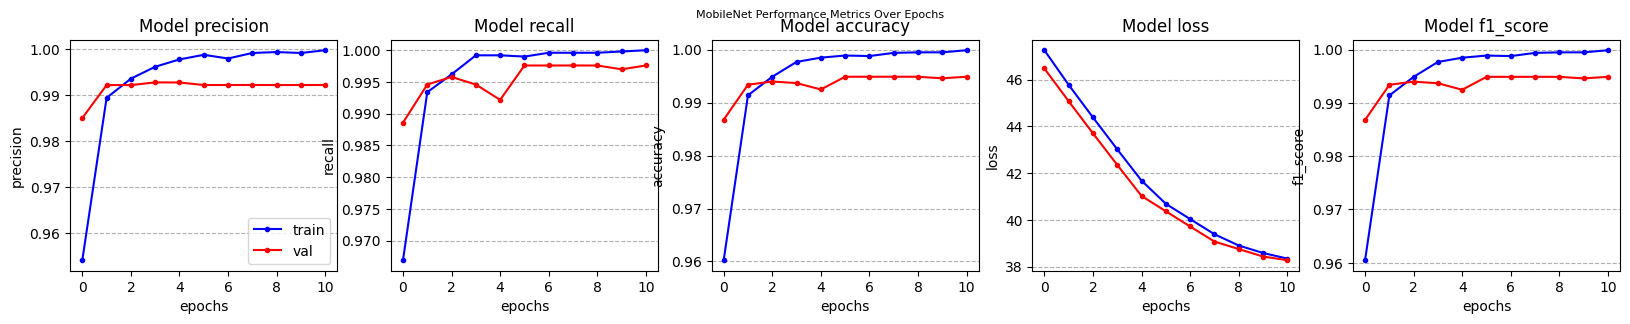

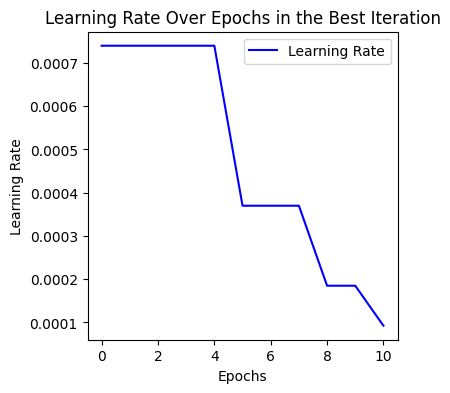

In [28]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss', 'f1_score']):
    ax[i].plot(MobileNet_best_history.history[met], color='blue', linestyle='-', marker='o', markersize=3)
    ax[i].plot(MobileNet_best_history.history['val_' + met], color='red', linestyle='-', marker='o', markersize=3)
    if i == 0:
        ax[i].legend(['train', 'val'])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(axis='y', linestyle='--')

plt.suptitle('MobileNet Performance Metrics Over Epochs', fontsize=8)
plt.show()

# print the learning rate
plt.figure(figsize=(4, 4))
plt.plot(MobileNet_best_history.history['lr'], label='Learning Rate', color='b')
plt.title('Learning Rate Over Epochs in the Best Iteration')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

### ResNet

In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from tensorflow.keras import backend as K

def build_ResNet_model(dropout_rate, optimizer_choice, learning_rate, l1_reg, l2_reg, fc_units):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # for layer in base_model.layers:
    #     layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(fc_units, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5)
                  ])
    return model

def fit_ResNet(lr, batch_size_index, optimizer_index, dropout_rate, l1_reg, l2_reg, fc_units_index):
    K.clear_session()
    
    batch_sizes = [8, 16, 32]
    optimizer_choices = ['adam', 'sgd', 'rmsprop']
    fc_units_choices = [128, 256, 512]

    batch_size = batch_sizes[int(batch_size_index)]
    optimizer_choice = optimizer_choices[int(optimizer_index)]
    fc_units = fc_units_choices[int(fc_units_index)]
    print(f'Current batch size is {batch_size} and fc_units is {fc_units}')

    ResNet_model = build_ResNet_model(dropout_rate=dropout_rate, optimizer_choice=optimizer_choice, learning_rate=lr, l1_reg=l1_reg, l2_reg=l2_reg, fc_units=fc_units)

    train_ds_local = change_batch_size(batch_size, train_ds)
    val_ds_local = change_batch_size(batch_size, val_ds)

    steps_per_epoch = max(1, TRAIN_IMG_COUNT // batch_size)
    validation_steps = max(1, VAL_IMG_COUNT // batch_size)

    ResNet_history = ResNet_model.fit(
        train_ds_local,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        verbose=1,
        validation_data=val_ds_local,
        validation_steps=validation_steps,
        callbacks=normal_callbacks
    )
    best_accuracy = max(ResNet_history.history['val_accuracy'])
    return best_accuracy

HP_range = {
    'lr': (1e-4, 1e-3),
    'batch_size_index': (0, 3),
    'optimizer_index': (0, 3),
    'dropout_rate': (0.0, 0.5),
    'l1_reg': (1e-5, 1e-2),
    'l2_reg': (1e-5, 1e-2),
    'fc_units_index': (0, 3)
}

ResNet_optimizer = BayesianOptimization(
    f=fit_ResNet,
    pbounds=HP_range,
    random_state=42,
    verbose=2
)

logger = JSONLogger(path="./ResNet_stage_1_logs.json")
ResNet_optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

ResNet_optimizer.maximize(init_points=2, n_iter=10)

Current batch size is 16 and fc_units is 512
Epoch 1/10
624/624 [==============================] - 63s 95ms/step - loss: 42.6280 - accuracy: 0.9636 - precision: 0.9584 - recall: 0.9693 - f1_score: 0.9638 - val_loss: 10.8524 - val_accuracy: 0.4997 - val_precision: 0.4997 - val_recall: 1.0000 - val_f1_score: 0.6664 - lr: 2.4040e-04
Epoch 2/10
624/624 [==============================] - 59s 94ms/step - loss: 9.0798 - accuracy: 0.9806 - precision: 0.9756 - recall: 0.9858 - f1_score: 0.9807 - val_loss: 9.5522 - val_accuracy: 0.9799 - val_precision: 0.9618 - val_recall: 0.9994 - val_f1_score: 0.9803 - lr: 2.4040e-04
Epoch 3/10
624/624 [==============================] - 59s 94ms/step - loss: 8.2169 - accuracy: 0.9935 - precision: 0.9912 - recall: 0.9958 - f1_score: 0.9935 - val_loss: 9.7574 - val_accuracy: 0.7698 - val_precision: 0.6901 - val_recall: 0.9796 - val_f1_score: 0.8097 - lr: 2.4040e-04
Epoch 4/10
624/624 [==============================] - 59s 94ms/step - loss: 8.1530 - accuracy: 0.9

In [30]:
# Define the mapping table
batch_sizes = [8, 16, 32]
optimizer_choices = ['adam', 'sgd', 'rmsprop']
fc_units_choices = [128, 256, 512]

# Initialize variables to store the best results
best_iteration = None
best_target = float('-inf')

# Print the result of each iteration
print("The result of all iterations of ResNet:")
for i, res in enumerate(ResNet_optimizer.res):
    params = res['params']
    readable_params = {
        'batch_size': batch_sizes[int(params['batch_size_index'])],
        'optimizer': optimizer_choices[int(params['optimizer_index'])],
        'fc_units': fc_units_choices[int(params['fc_units_index'])],
        'dropout_rate': params['dropout_rate'],
        'l1_reg': params['l1_reg'],
        'l2_reg': params['l2_reg'],
        'lr': params['lr']
    }
    # Print the result of each iteration
    print(f"Iteration {i+1}:")
    print(f"Target: {res['target']:.4f}")
    print("Hyperparameters:")
    for key, value in readable_params.items():
        print(f"  {key}: {value}")
    print()

    # Update the best iteration result
    if res['target'] > best_target:
        best_target = res['target']
        best_iteration = (i+1, readable_params, best_target)

# Print the best result
if best_iteration:
    iteration_number, params, target = best_iteration
    print("The best result of ResNet is:")
    print(f"Iteration {iteration_number}:")
    print(f"Target: {target:.4f}")
    print("Parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")

The result of all iterations of ResNet:
Iteration 1:
Target: 0.9979
Hyperparameters:
  batch_size: 16
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.4753571532049581
  l1_reg: 0.005990598257128396
  l2_reg: 0.001568626218019941
  lr: 0.00024039506830258236

Iteration 2:
Target: 0.9943
Hyperparameters:
  batch_size: 32
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.3005575058716044
  l1_reg: 0.00021563909801506647
  l2_reg: 0.009699399423098323
  lr: 0.0008491983767203796

Iteration 3:
Target: 0.9982
Hyperparameters:
  batch_size: 16
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.4211410493741079
  l1_reg: 0.009921592837948181
  l2_reg: 0.0061390116803479505
  lr: 0.0005169309439550524

Iteration 4:
Target: 0.9994
Hyperparameters:
  batch_size: 8
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.2666151559635361
  l1_reg: 0.008297455854812489
  l2_reg: 0.008414716782667636
  lr: 0.0006421695649998251

Iteration 5:
Target: 0.9420
Hyperparameters:
  batch_size: 8
  optimi

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

ResNet_callbacks = [
    EarlyStopping(patience=5, verbose=1, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-8, verbose=1, monitor='val_accuracy'),
    ModelCheckpoint('stage_1_model-ResNet.weights.h5', verbose=1, save_best_only=True, monitor='val_accuracy'),
]

In [32]:
ResNet_best_params = ResNet_optimizer.max['params']

best_lr = ResNet_best_params['lr']
best_batch_size_index = int(ResNet_best_params['batch_size_index'])
best_optimizer_index = int(ResNet_best_params['optimizer_index'])
best_dropout_rate = ResNet_best_params['dropout_rate']
best_l1_reg = ResNet_best_params['l1_reg']
best_l2_reg = ResNet_best_params['l2_reg']
best_fc_units_index = int(ResNet_best_params['fc_units_index'])

best_batch_size = batch_sizes[best_batch_size_index]
best_optimizer_choice = optimizer_choices[best_optimizer_index]
best_fc_units = fc_units_choices[best_fc_units_index]

K.clear_session()
ResNet_best_model = build_ResNet_model(dropout_rate=best_dropout_rate, optimizer_choice=best_optimizer_choice, learning_rate=best_lr, l1_reg=best_l1_reg, l2_reg=best_l2_reg, fc_units=best_fc_units)

train_ds_local = change_batch_size(best_batch_size, train_ds)
val_ds_local = change_batch_size(best_batch_size, val_ds)

steps_per_epoch = max(1, TRAIN_IMG_COUNT // best_batch_size)
validation_steps = max(1, VAL_IMG_COUNT // best_batch_size)

ResNet_best_history = ResNet_best_model.fit(
    train_ds_local,
    steps_per_epoch=steps_per_epoch,
    epochs=12,
    validation_data=val_ds_local,
    validation_steps=validation_steps,
    callbacks=ResNet_callbacks
)

new_best_accuracy = max(ResNet_best_history.history['val_accuracy'])
print("The new best accuracy in ResNet is:", new_best_accuracy)

Epoch 1/12
312/312 [==============================] - ETA: 0s - loss: 22.0557 - accuracy: 0.9035 - precision: 0.8943 - recall: 0.9152 - f1_score: 0.9046
Epoch 1: val_accuracy improved from -inf to 0.50060, saving model to stage_1_model-ResNet.weights.h5
312/312 [==============================] - 62s 185ms/step - loss: 22.0557 - accuracy: 0.9035 - precision: 0.8943 - recall: 0.9152 - f1_score: 0.9046 - val_loss: 36.8787 - val_accuracy: 0.5006 - val_precision: 0.5006 - val_recall: 1.0000 - val_f1_score: 0.6672 - lr: 8.2737e-04
Epoch 2/12
312/312 [==============================] - ETA: 0s - loss: 18.1468 - accuracy: 0.9529 - precision: 0.9475 - recall: 0.9589 - f1_score: 0.9532
Epoch 2: val_accuracy did not improve from 0.50060
312/312 [==============================] - 57s 182ms/step - loss: 18.1468 - accuracy: 0.9529 - precision: 0.9475 - recall: 0.9589 - f1_score: 0.9532 - val_loss: 43.2302 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1_score: 0.6667 - lr:

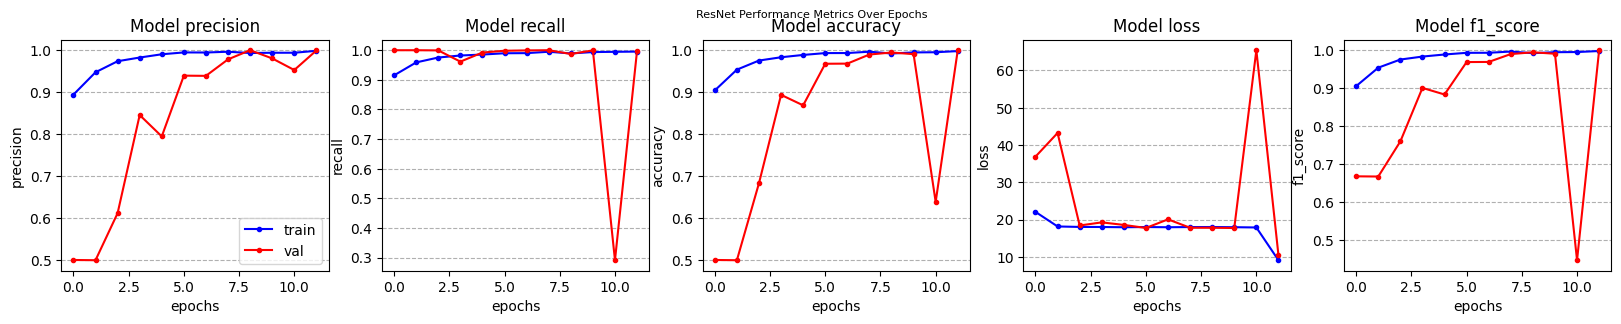

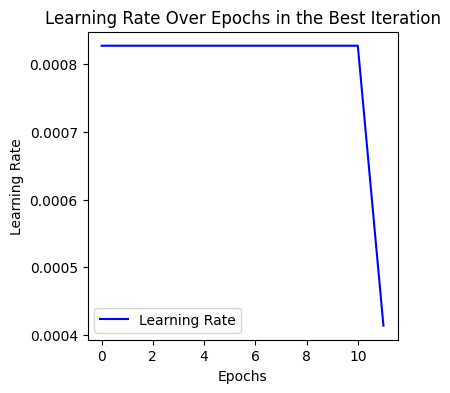

In [33]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss', 'f1_score']):
    ax[i].plot(ResNet_best_history.history[met], color='blue', linestyle='-', marker='o', markersize=3)
    ax[i].plot(ResNet_best_history.history['val_' + met], color='red', linestyle='-', marker='o', markersize=3)
    if i == 0:
        ax[i].legend(['train', 'val'])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(axis='y', linestyle='--')

plt.suptitle('ResNet Performance Metrics Over Epochs', fontsize=8)
plt.show()

# print the learning rate
plt.figure(figsize=(4, 4))
plt.plot(ResNet_best_history.history['lr'], label='Learning Rate', color='b')
plt.title('Learning Rate Over Epochs in the Best Iteration')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

### EfficientNetB0

In [34]:
from tensorflow.keras.applications import EfficientNetB0

def build_EfficientNetB0_model(dropout_rate, optimizer_choice, learning_rate, l1_reg, l2_reg, fc_units):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # for layer in base_model.layers:
    #     layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(fc_units, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5)
                  ])
    return model

def fit_EfficientNetB0(lr, batch_size_index, optimizer_index, dropout_rate, l1_reg, l2_reg, fc_units_index):
    K.clear_session()
    
    batch_sizes = [8, 16, 32]
    optimizer_choices = ['adam', 'sgd', 'rmsprop']
    fc_units_choices = [128, 256, 512]

    batch_size = batch_sizes[int(batch_size_index)]
    optimizer_choice = optimizer_choices[int(optimizer_index)]
    fc_units = fc_units_choices[int(fc_units_index)]
    print(f'Current batch size is {batch_size} and fc_units is {fc_units}')

    EfficientNetB0_model = build_EfficientNetB0_model(dropout_rate=dropout_rate, optimizer_choice=optimizer_choice, learning_rate=lr, l1_reg=l1_reg, l2_reg=l2_reg, fc_units=fc_units)

    train_ds_local = change_batch_size(batch_size, train_ds)
    val_ds_local = change_batch_size(batch_size, val_ds)

    steps_per_epoch = max(1, TRAIN_IMG_COUNT // batch_size)
    validation_steps = max(1, VAL_IMG_COUNT // batch_size)

    EfficientNetB0_history = EfficientNetB0_model.fit(
        train_ds_local,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        verbose=1,
        validation_data=val_ds_local,
        validation_steps=validation_steps,
        callbacks=normal_callbacks
    )
    best_accuracy = max(EfficientNetB0_history.history['val_accuracy'])
    return best_accuracy

HP_range = {
    'lr': (1e-4, 1e-3),
    'batch_size_index': (0, 3),
    'optimizer_index': (0, 3),
    'dropout_rate': (0.0, 0.5),
    'l1_reg': (1e-5, 1e-2),
    'l2_reg': (1e-5, 1e-2),
    'fc_units_index': (0, 3)
}

EfficientNetB0_optimizer = BayesianOptimization(
    f=fit_EfficientNetB0,
    pbounds=HP_range,
    random_state=42,
    verbose=2
)

logger = JSONLogger(path="./EfficientNetB0_stage_1_logs.json")
EfficientNetB0_optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

EfficientNetB0_optimizer.maximize(init_points=2, n_iter=10)

Current batch size is 16 and fc_units is 512
Epoch 1/10
624/624 [==============================] - 58s 87ms/step - loss: 32.1814 - accuracy: 0.9801 - precision: 0.9771 - recall: 0.9832 - f1_score: 0.9801 - val_loss: 7.6033 - val_accuracy: 0.3218 - val_precision: 0.3854 - val_recall: 0.5992 - val_f1_score: 0.4691 - lr: 2.4040e-04
Epoch 2/10
624/624 [==============================] - 53s 85ms/step - loss: 6.2603 - accuracy: 0.9921 - precision: 0.9891 - recall: 0.9952 - f1_score: 0.9921 - val_loss: 6.9156 - val_accuracy: 0.5189 - val_precision: 0.5095 - val_recall: 0.9952 - val_f1_score: 0.6740 - lr: 2.4040e-04
Epoch 3/10
624/624 [==============================] - 53s 85ms/step - loss: 6.5028 - accuracy: 0.9955 - precision: 0.9936 - recall: 0.9974 - f1_score: 0.9955 - val_loss: 6.4488 - val_accuracy: 0.4991 - val_precision: 0.4997 - val_recall: 0.9802 - val_f1_score: 0.6619 - lr: 2.4040e-04
Epoch 4/10
624/624 [==============================] - ETA: 0s - loss: 5.6501 - accuracy: 0.9967 - p

In [35]:
# Define the mapping table
batch_sizes = [8, 16, 32]
optimizer_choices = ['adam', 'sgd', 'rmsprop']
fc_units_choices = [128, 256, 512]

# Initialize variables to store the best results
best_iteration = None
best_target = float('-inf')

# Print the result of each iteration
print("The result of all iterations of EfficientNetB0:")
for i, res in enumerate(EfficientNetB0_optimizer.res):
    params = res['params']
    readable_params = {
        'batch_size': batch_sizes[int(params['batch_size_index'])],
        'optimizer': optimizer_choices[int(params['optimizer_index'])],
        'fc_units': fc_units_choices[int(params['fc_units_index'])],
        'dropout_rate': params['dropout_rate'],
        'l1_reg': params['l1_reg'],
        'l2_reg': params['l2_reg'],
        'lr': params['lr']
    }
    # Print the result of each iteration
    print(f"Iteration {i+1}:")
    print(f"Target: {res['target']:.4f}")
    print("Hyperparameters:")
    for key, value in readable_params.items():
        print(f"  {key}: {value}")
    print()

    # Update the best iteration result
    if res['target'] > best_target:
        best_target = res['target']
        best_iteration = (i+1, readable_params, best_target)

# print the best result
if best_iteration:
    iteration_number, params, target = best_iteration
    print("The best result of EfficientNetB0 is:")
    print(f"Iteration {iteration_number}:")
    print(f"Target: {target:.4f}")
    print("Parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")

The result of all iterations of EfficientNetB0:
Iteration 1:
Target: 0.9973
Hyperparameters:
  batch_size: 16
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.4753571532049581
  l1_reg: 0.005990598257128396
  l2_reg: 0.001568626218019941
  lr: 0.00024039506830258236

Iteration 2:
Target: 0.9727
Hyperparameters:
  batch_size: 32
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.3005575058716044
  l1_reg: 0.00021563909801506647
  l2_reg: 0.009699399423098323
  lr: 0.0008491983767203796

Iteration 3:
Target: 0.7332
Hyperparameters:
  batch_size: 16
  optimizer: adam
  fc_units: 512
  dropout_rate: 0.4211410493741079
  l1_reg: 0.009921592837948181
  l2_reg: 0.0061390116803479505
  lr: 0.0005169309439550524

Iteration 4:
Target: 0.9531
Hyperparameters:
  batch_size: 8
  optimizer: sgd
  fc_units: 512
  dropout_rate: 0.054484951089545486
  l1_reg: 0.008500967984334864
  l2_reg: 0.007521067762899238
  lr: 0.00035104356423172725

Iteration 5:
Target: 0.5303
Hyperparameters:
  batch_size: 

In [36]:
# EfficientNetB0 Callbacks
efficientnetb0_callbacks = [
    EarlyStopping(patience=5, verbose=1, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-8, verbose=1, monitor='val_accuracy'),
    ModelCheckpoint('stage_1-model-EfficientNetB0.h5', verbose=1, save_best_only=True, monitor='val_accuracy', save_weights_only=True),
]

In [37]:
EfficientNetB0_best_params = EfficientNetB0_optimizer.max['params']

best_lr = EfficientNetB0_best_params['lr']
best_batch_size_index = int(EfficientNetB0_best_params['batch_size_index'])
best_optimizer_index = int(EfficientNetB0_best_params['optimizer_index'])
best_dropout_rate = EfficientNetB0_best_params['dropout_rate']
best_l1_reg = EfficientNetB0_best_params['l1_reg']
best_l2_reg = EfficientNetB0_best_params['l2_reg']
best_fc_units_index = int(EfficientNetB0_best_params['fc_units_index'])

best_batch_size = batch_sizes[best_batch_size_index]
best_optimizer_choice = optimizer_choices[best_optimizer_index]
best_fc_units = fc_units_choices[best_fc_units_index]

K.clear_session()
EfficientNetB0_best_model = build_EfficientNetB0_model(dropout_rate=best_dropout_rate, optimizer_choice=best_optimizer_choice, learning_rate=best_lr, l1_reg=best_l1_reg, l2_reg=best_l2_reg, fc_units=best_fc_units)

train_ds_local = change_batch_size(best_batch_size, train_ds)
val_ds_local = change_batch_size(best_batch_size, val_ds)

steps_per_epoch = max(1, TRAIN_IMG_COUNT // best_batch_size)
validation_steps = max(1, VAL_IMG_COUNT // best_batch_size)

EfficientNetB0_best_history = EfficientNetB0_best_model.fit(
    train_ds_local,
    steps_per_epoch=steps_per_epoch,
    epochs=12,
    validation_data=val_ds_local,
    validation_steps=validation_steps,
    callbacks=efficientnetb0_callbacks
)

new_best_accuracy = max(EfficientNetB0_best_history.history['val_accuracy'])
print("The new best accuracy in EfficientNetB0 is:", new_best_accuracy)

Epoch 1/12
624/624 [==============================] - ETA: 0s - loss: 33.8803 - accuracy: 0.9764 - precision: 0.9729 - recall: 0.9800 - f1_score: 0.9764
Epoch 1: val_accuracy improved from -inf to 0.44231, saving model to stage_1-model-EfficientNetB0.h5
624/624 [==============================] - 58s 87ms/step - loss: 33.8803 - accuracy: 0.9764 - precision: 0.9729 - recall: 0.9800 - f1_score: 0.9764 - val_loss: 6.9257 - val_accuracy: 0.4423 - val_precision: 0.2216 - val_recall: 0.0456 - val_f1_score: 0.0757 - lr: 2.4040e-04
Epoch 2/12
624/624 [==============================] - ETA: 0s - loss: 6.2260 - accuracy: 0.9944 - precision: 0.9926 - recall: 0.9962 - f1_score: 0.9944
Epoch 2: val_accuracy improved from 0.44231 to 0.54958, saving model to stage_1-model-EfficientNetB0.h5
624/624 [==============================] - 54s 86ms/step - loss: 6.2260 - accuracy: 0.9944 - precision: 0.9926 - recall: 0.9962 - f1_score: 0.9944 - val_loss: 7.4689 - val_accuracy: 0.5496 - val_precision: 0.5261 - 

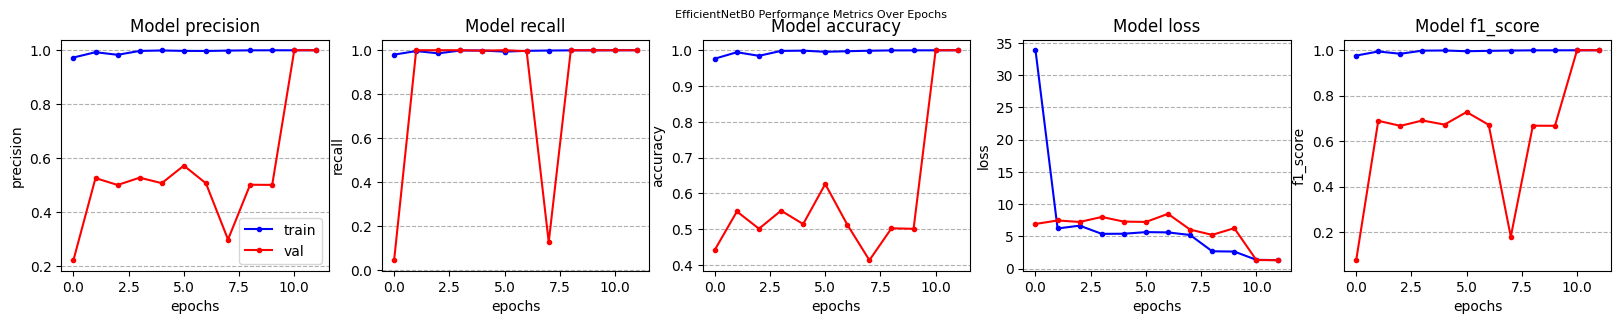

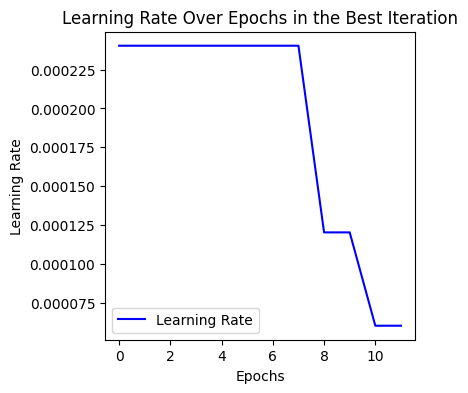

In [38]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss', 'f1_score']):
    ax[i].plot(EfficientNetB0_best_history.history[met], color='blue', linestyle='-', marker='o', markersize=3)
    ax[i].plot(EfficientNetB0_best_history.history['val_' + met], color='red', linestyle='-', marker='o', markersize=3)
    if i == 0:
        ax[i].legend(['train', 'val'])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(axis='y', linestyle='--')

plt.suptitle('EfficientNetB0 Performance Metrics Over Epochs', fontsize=8)
plt.show()

# print the learning rate
plt.figure(figsize=(4, 4))
plt.plot(EfficientNetB0_best_history.history['lr'], label='Learning Rate', color='b')
plt.title('Learning Rate Over Epochs in the Best Iteration')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

## Select the best model

In [39]:
from tensorflow.keras.models import load_model

def evaluate_model(model_type, optimizer, model_file_name, train_ds, val_ds, train_img_count, val_img_count):
    # Get the best parameters from the optimizer
    best_params = optimizer.max['params']
    best_batch_size_index = int(best_params['batch_size_index'])

    # Define the mapping of batch size
    batch_sizes = [8, 16, 32]
    best_batch_size = batch_sizes[best_batch_size_index]

    # Load the best model
    best_model = load_model(model_file_name)

    # Adjust the dataset batch size
    train_ds_local = change_batch_size(best_batch_size, train_ds)
    val_ds_local = change_batch_size(best_batch_size, val_ds)

    # Evaluate the model's performance on the training and validation sets
    print(f'{model_type} Train result:')
    train_results = best_model.evaluate(train_ds_local, steps=train_img_count // best_batch_size)
    print(f'{model_type} Validation result:')
    val_results = best_model.evaluate(val_ds_local, steps=val_img_count // best_batch_size)

    # Print the model's results
    print(f"Best {model_type} model performance:")
    print(f"Training set: Loss = {train_results[0]:.4f}, Accuracy = {train_results[1]:.4f}")
    print(f"Validation set: Loss = {val_results[0]:.4f}, Accuracy = {val_results[1]:.4f}")

    # Print the model summary
    best_model.summary()
    return best_batch_size, best_model

VGG16

In [40]:
best_batch_size_VGG16, best_VGGNet_model = evaluate_model(
    model_type='VGG16',
    optimizer=VGG16_optimizer,
    model_file_name='stage_1_model-VGGNet.weights.h5',
    train_ds=train_ds,
    val_ds=val_ds,
    train_img_count=TRAIN_IMG_COUNT,
    val_img_count=VAL_IMG_COUNT
)

VGG16 Train result:
312/312 [==============================] - 14s 44ms/step - loss: 0.0903 - accuracy: 0.9977 - precision: 0.9968 - recall: 0.9986 - f1_score: 0.9977
VGG16 Validation result:
104/104 [==============================] - 4s 43ms/step - loss: 0.1159 - accuracy: 0.9880 - precision: 0.9822 - recall: 0.9940 - f1_score: 0.9880
Best VGG16 model performance:
Training set: Loss = 0.0903, Accuracy = 0.9977
Validation set: Loss = 0.1159, Accuracy = 0.9880
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                           

DenseNet-121

In [41]:
best_batch_size_DenseNet, best_DenseNet_model= evaluate_model(
    model_type='DenseNet',
    optimizer=DenseNet121_optimizer,
    model_file_name='stage_1_model-DenseNet.weights.h5',
    train_ds=train_ds,
    val_ds=val_ds,
    train_img_count=TRAIN_IMG_COUNT,
    val_img_count=VAL_IMG_COUNT
)

DenseNet Train result:
312/312 [==============================] - 15s 46ms/step - loss: 0.3028 - accuracy: 0.9993 - precision: 0.9992 - recall: 0.9994 - f1_score: 0.9993
DenseNet Validation result:
104/104 [==============================] - 5s 46ms/step - loss: 0.3118 - accuracy: 0.9961 - precision: 0.9958 - recall: 0.9964 - f1_score: 0.9961
Best DenseNet model performance:
Training set: Loss = 0.3028, Accuracy = 0.9993
Validation set: Loss = 0.3118, Accuracy = 0.9961
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (

MobileNet

In [42]:
# Evaluate MobileNet
best_batch_size_MobileNet, best_MobileNet_model = evaluate_model(
    model_type='MobileNet',
    optimizer=MobileNet_optimizer,
    model_file_name='stage_1_model-MobileNet.weights.h5',
    train_ds=train_ds,
    val_ds=val_ds,
    train_img_count=TRAIN_IMG_COUNT,
    val_img_count=VAL_IMG_COUNT
)

MobileNet Train result:
312/312 [==============================] - 5s 15ms/step - loss: 40.3558 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000
MobileNet Validation result:
104/104 [==============================] - 2s 15ms/step - loss: 40.3679 - accuracy: 0.9949 - precision: 0.9922 - recall: 0.9976 - f1_score: 0.9949
Best MobileNet model performance:
Training set: Loss = 40.3558, Accuracy = 1.0000
Validation set: Loss = 40.3679, Accuracy = 0.9949
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                         

ResNet

In [43]:
# Evaluate ResNet
best_batch_size_ResNet, best_ResNet_model, = evaluate_model(
    model_type='ResNet',
    optimizer=ResNet_optimizer,
    model_file_name='stage_1_model-ResNet.weights.h5',
    train_ds=train_ds,
    val_ds=val_ds,
    train_img_count=TRAIN_IMG_COUNT,
    val_img_count=VAL_IMG_COUNT
)

ResNet Train result:
312/312 [==============================] - 11s 35ms/step - loss: 10.4857 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - f1_score: 0.9999
ResNet Validation result:
104/104 [==============================] - 4s 34ms/step - loss: 10.4871 - accuracy: 0.9991 - precision: 0.9994 - recall: 0.9988 - f1_score: 0.9991
Best ResNet model performance:
Training set: Loss = 10.4857, Accuracy = 0.9999
Validation set: Loss = 10.4871, Accuracy = 0.9991
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPad

EfficientNetB0

In [44]:
from tensorflow.keras.models import load_model

# Assume optimizer has already executed maximize method
best_params_efficientnetb0 = EfficientNetB0_optimizer.max['params']
best_batch_size_index_efficientnetb0 = int(best_params_efficientnetb0['batch_size_index'])

# Define the mapping of batch size
batch_sizes = [8, 16, 32]

# Get the actual batch size for EfficientNetB0
best_batch_size_efficientnetb0 = batch_sizes[best_batch_size_index_efficientnetb0]

# 重新构建模型结构
best_EfficientNetB0_model = build_EfficientNetB0_model(
       dropout_rate=best_dropout_rate,
       optimizer_choice=best_optimizer_choice,
       learning_rate=best_lr,
       l1_reg=best_l1_reg,
       l2_reg=best_l2_reg,
       fc_units=best_fc_units
   )

   # 加载权重
best_EfficientNetB0_model.load_weights('stage_1-model-EfficientNetB0.h5')


train_ds_local_efficientnetb0 = change_batch_size(best_batch_size_efficientnetb0, train_ds)
val_ds_local_efficientnetb0 = change_batch_size(best_batch_size_efficientnetb0, val_ds)

# Evaluate the best EfficientNetB0 model's performance on the training and validation sets
print('EfficientNetB0 Train result:')
train_results_efficientnetb0 = best_EfficientNetB0_model.evaluate(train_ds_local_efficientnetb0, steps=TRAIN_IMG_COUNT // best_batch_size_efficientnetb0)
print('EfficientNetB0 Validation result:')
val_results_efficientnetb0 = best_EfficientNetB0_model.evaluate(val_ds_local_efficientnetb0, steps=VAL_IMG_COUNT // best_batch_size_efficientnetb0)

# Print the best EfficientNetB0 model's results
print("Best EfficientNetB0 model performance:")
print("Training set: Loss = {:.4f}, Accuracy = {:.4f}".format(train_results_efficientnetb0[0], train_results_efficientnetb0[1]))
print("Validation set: Loss = {:.4f}, Accuracy = {:.4f}".format(val_results_efficientnetb0[0], val_results_efficientnetb0[1]))

EfficientNetB0 Train result:
624/624 [==============================] - 14s 20ms/step - loss: 1.3335 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000
EfficientNetB0 Validation result:
208/208 [==============================] - 4s 20ms/step - loss: 1.3337 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000
Best EfficientNetB0 model performance:
Training set: Loss = 1.3335, Accuracy = 1.0000
Validation set: Loss = 1.3337, Accuracy = 1.0000


In [45]:
best_EfficientNetB0_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

## Comparing the model using testing dataset

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

def evaluate_model_performance(model, test_ds, batch_size, class_names, model_name):
    # Unbatch the test dataset
    test_ds = test_ds.unbatch()
    test_ds_local = test_ds.batch(batch_size)

    # Predict labels for the test dataset
    predictions = model.predict(test_ds_local)
    
    # Assume model outputs probabilities or logits, take the probability of the positive class
    if predictions.shape[-1] == 1:
        # Model outputs a single probability
        predicted_probs = predictions.ravel()
        predicted_labels = (predicted_probs >= 0.5).astype(int)
    else:
        # Model outputs two probabilities, take the probability of the positive class
        predicted_probs = predictions[:, 1]
        predicted_labels = np.argmax(predictions, axis=-1)

    # Get true labels
    true_labels = []
    for _, labels in test_ds_local.unbatch():
        label = labels.numpy()
        if label.ndim > 1 and label.shape[-1] > 1:
            # One-hot encoding
            label = np.argmax(label, axis=-1)
        else:
            # Already integers
            label = label.squeeze()
        true_labels.append(label)
    true_labels = np.array(true_labels).astype(int)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Calculate F1 score and AUC-ROC
    f1 = f1_score(true_labels, predicted_labels)
    auc_roc = roc_auc_score(true_labels, predicted_probs)

    # Print classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Print AUC-ROC score
    print(f"{model_name} AUC-ROC: {auc_roc:.4f}")
    # Print F1 score
    print(f"{model_name} F1 Score: {f1:.4f}")

    # Visualize confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc_value = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_value:.2f})')
    # Draw the diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [47]:
class_names = ['True', 'False']

VGG-16

105/105 [==============================] - 6s 59ms/step
VGG16 Classification Report:
              precision    recall  f1-score   support

        True       1.00      0.99      0.99      1668
       False       0.99      1.00      0.99      1668

    accuracy                           0.99      3336
   macro avg       0.99      0.99      0.99      3336
weighted avg       0.99      0.99      0.99      3336

VGG16 AUC-ROC: 0.9997
VGG16 F1 Score: 0.9907


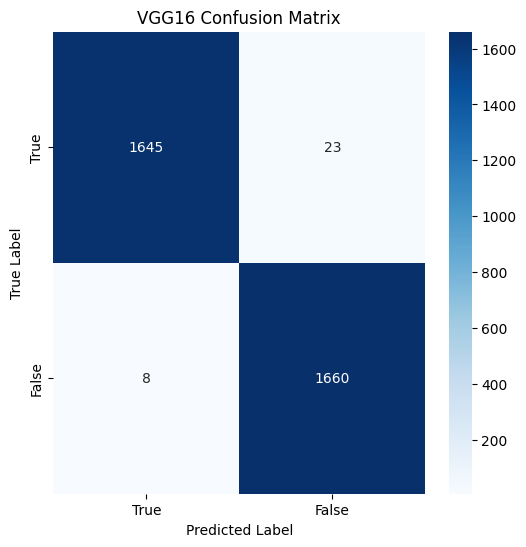

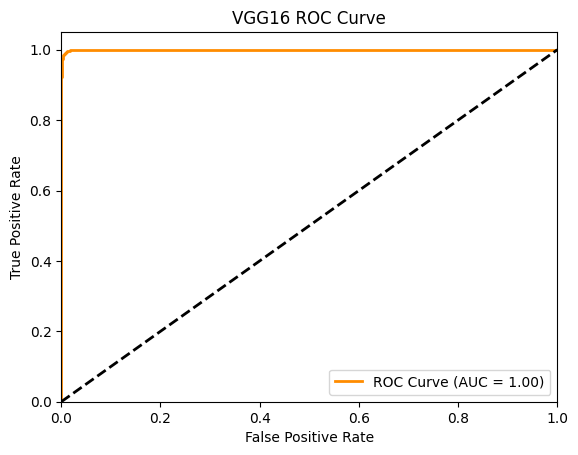

In [48]:
# Evaluate VGG16
evaluate_model_performance(
    model=best_VGGNet_model,
    test_ds=test_ds,
    batch_size=best_batch_size_VGG16,
    class_names=class_names,
    model_name='VGG16'
)

DenseNet 

105/105 [==============================] - 6s 54ms/step
DenseNet Classification Report:
              precision    recall  f1-score   support

        True       1.00      0.99      1.00      1668
       False       0.99      1.00      1.00      1668

    accuracy                           1.00      3336
   macro avg       1.00      1.00      1.00      3336
weighted avg       1.00      1.00      1.00      3336

DenseNet AUC-ROC: 0.9997
DenseNet F1 Score: 0.9961


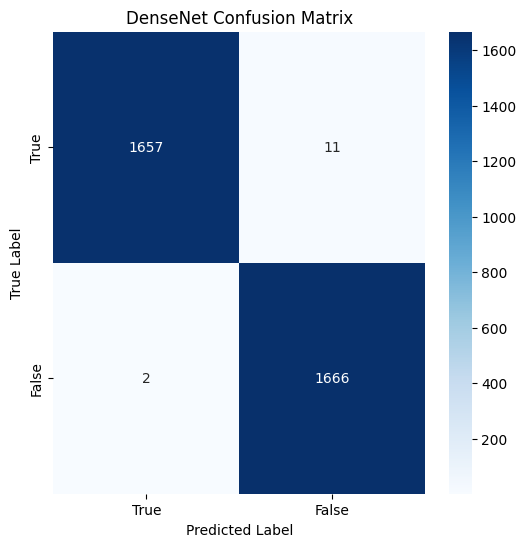

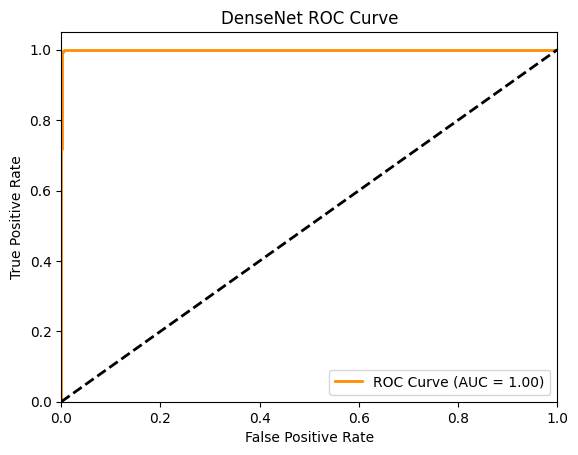

In [49]:
# Evaluate DenseNet
evaluate_model_performance(
    model=best_DenseNet_model,
    test_ds=test_ds,
    batch_size=best_batch_size_DenseNet,
    class_names=class_names,
    model_name='DenseNet'
)

MobileNet

105/105 [==============================] - 4s 40ms/step
MobileNet Classification Report:
              precision    recall  f1-score   support

        True       1.00      0.99      0.99      1668
       False       0.99      1.00      0.99      1668

    accuracy                           0.99      3336
   macro avg       0.99      0.99      0.99      3336
weighted avg       0.99      0.99      0.99      3336

MobileNet AUC-ROC: 0.9999
MobileNet F1 Score: 0.9946


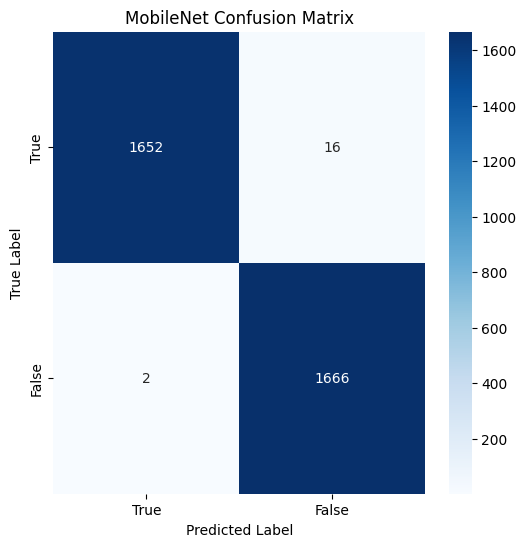

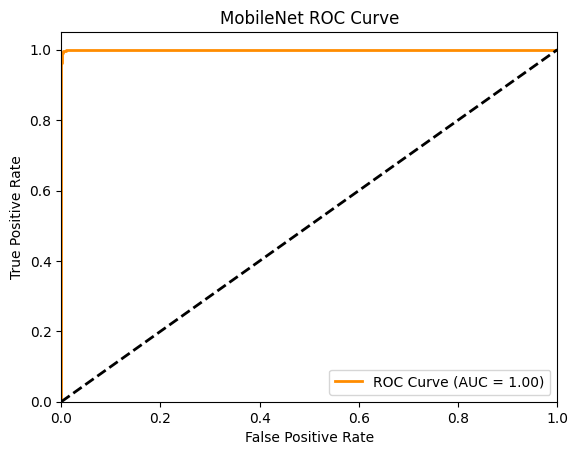

In [50]:
# Evaluate MobileNet
evaluate_model_performance(
    model=best_MobileNet_model,
    test_ds=test_ds,
    batch_size=best_batch_size_MobileNet,
    class_names=class_names,
    model_name='MobileNet'
)

ResNet

105/105 [==============================] - 5s 48ms/step
ResNet Classification Report:
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      1668
       False       1.00      1.00      1.00      1668

    accuracy                           1.00      3336
   macro avg       1.00      1.00      1.00      3336
weighted avg       1.00      1.00      1.00      3336

ResNet AUC-ROC: 1.0000
ResNet F1 Score: 0.9991


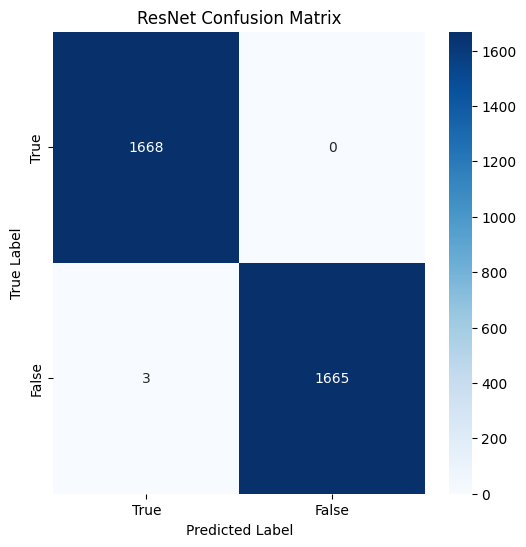

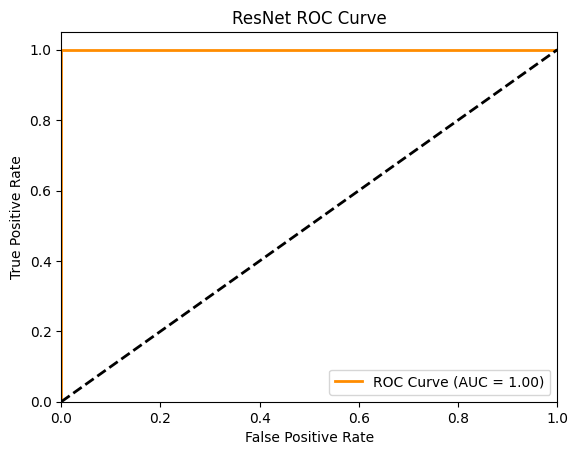

In [51]:
# Evaluate ResNet
evaluate_model_performance(
    model=best_ResNet_model,
    test_ds=test_ds,
    batch_size=best_batch_size_ResNet,
    class_names=class_names,
    model_name='ResNet'
)

EfficientNet

209/209 [==============================] - 6s 25ms/step
EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      1668
       False       1.00      1.00      1.00      1668

    accuracy                           1.00      3336
   macro avg       1.00      1.00      1.00      3336
weighted avg       1.00      1.00      1.00      3336

EfficientNetB0 AUC-ROC: 1.0000
EfficientNetB0 F1 Score: 1.0000


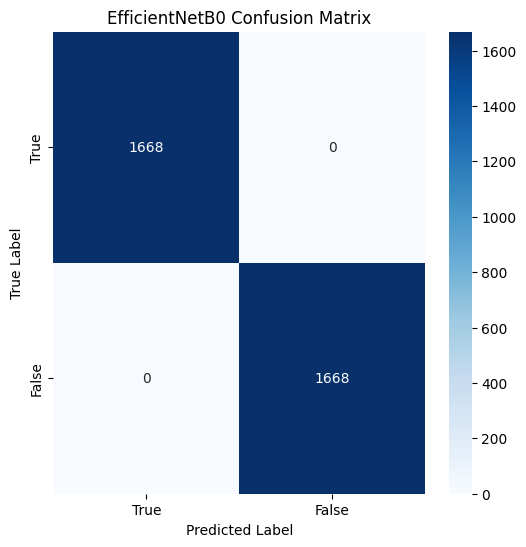

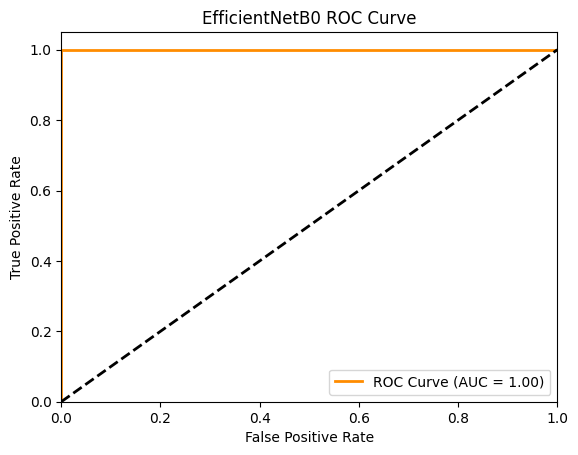

In [52]:
# Evaluate EfficientNetB0
evaluate_model_performance(
    model=best_EfficientNetB0_model,
    test_ds=test_ds,
    batch_size=best_batch_size_efficientnetb0,
    class_names=class_names,
    model_name='EfficientNetB0'
) 